# <center>Download the mereged data from Google Drive

In [1]:
import gdown

In [2]:
merged_data_file_id = '1o_EEumVnswul9MVsrdDwBch5rt7JTr0m'
merged_data_url = f'https://drive.google.com/uc?id={merged_data_file_id}'
output = '../temporary_files/merged.csv'
gdown.download(merged_data_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o_EEumVnswul9MVsrdDwBch5rt7JTr0m
To: c:\Users\Steven\Documents\Projects\ss24-capstone-team23-datallah-nkitts-steveso\temporary_files\merged.csv
100%|██████████| 438k/438k [00:00<00:00, 5.86MB/s]


'../temporary_files/merged.csv'

# <center> MeanBaseline Model

In [5]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [6]:
# Function to calculate the Mean Baseline
def get_baselines(df, window=12):
    mean_predictions = []
    actuals = []

    # Resetting index to avoid index-related issues
    df = df.reset_index(drop=True)  

    for i in range(window, len(df)):
        mean_predictions.append(df.loc[i-window:i-1, 'ZHVI'].mean())
        actuals.append(df.loc[i, 'ZHVI'])

    return mean_predictions, actuals

In [7]:
# Load merged data into DataFrame
merged_df = pd.read_csv('../temporary_files/merged.csv')

# Initialize dictionaries to store predictions and actuals
mean_preds = {}
actual_vals = {}
mse_results = {}

# Loop through each city to get predictions and calculate MSE
for city in merged_df['City'].unique():
    city_data = merged_df[merged_df['City'] == city].reset_index(drop=True)

    split_index = int(len(city_data) * 0.8)
    test_city_df = city_data.iloc[split_index:]

    mean_preds[city], actual_vals[city] = get_baselines(test_city_df)

    mse_results[city] = {
        'Mean MSE': mean_squared_error(actual_vals[city], mean_preds[city])
    }

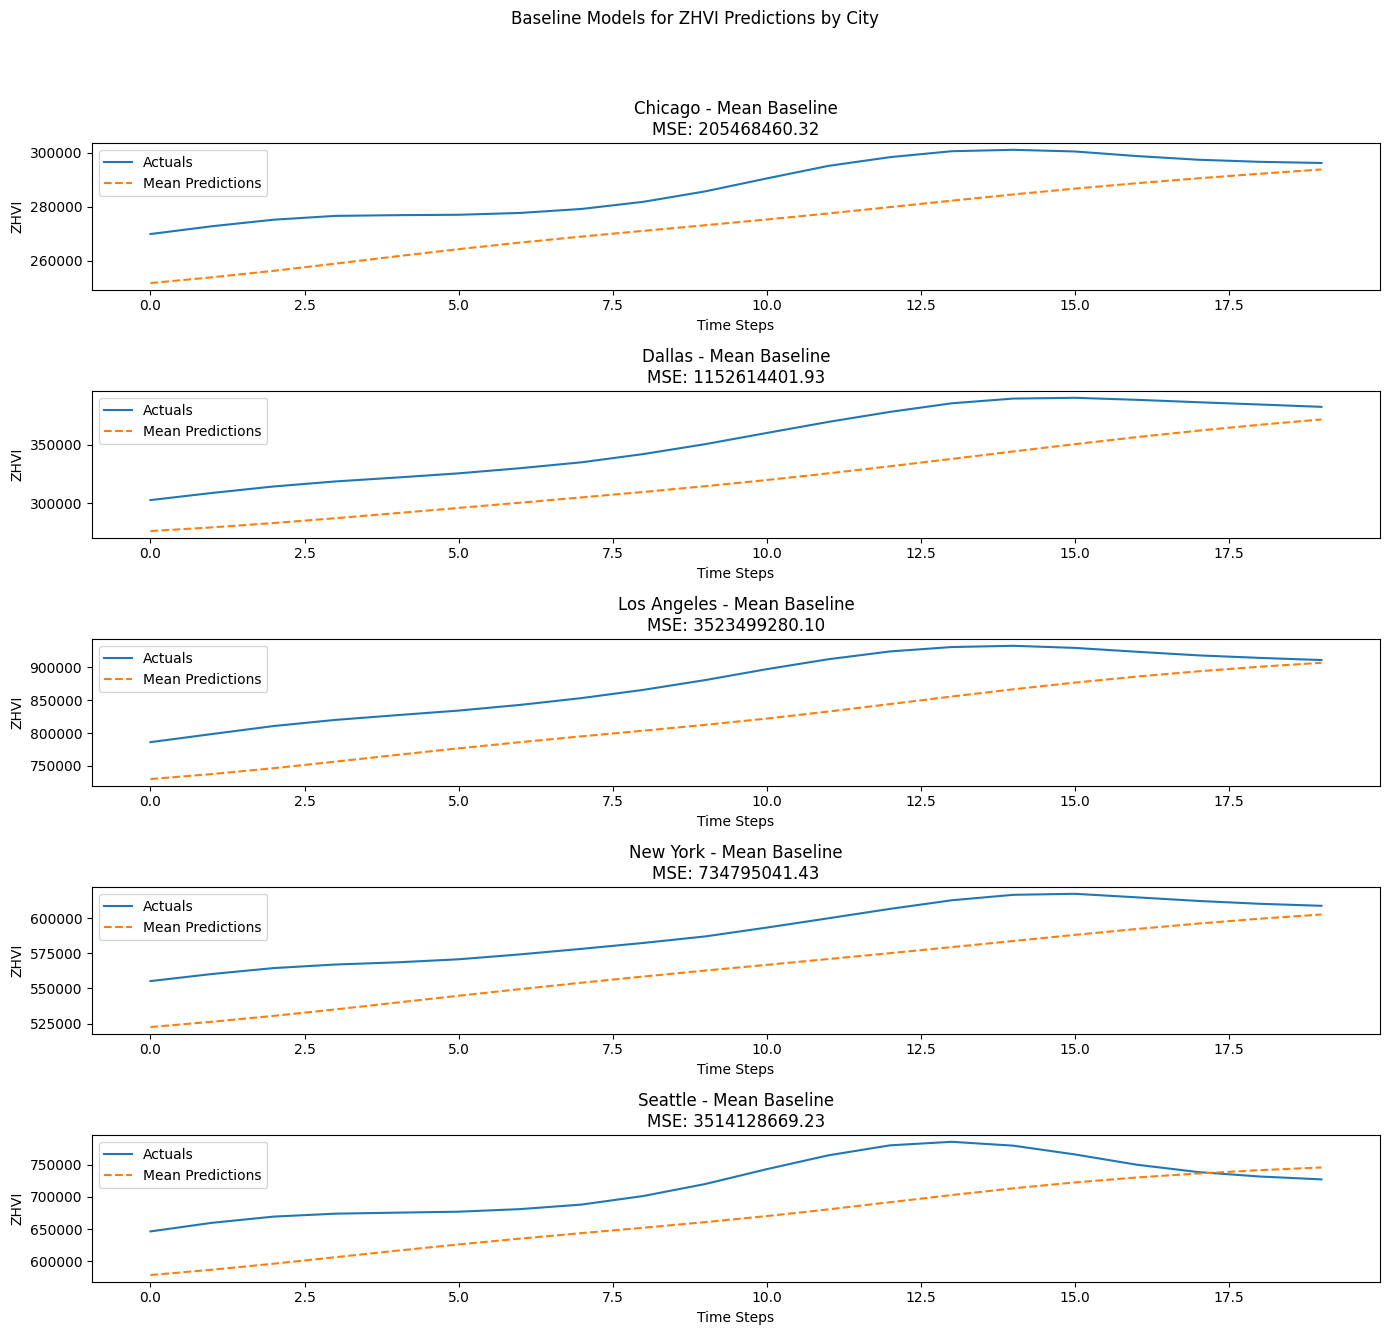

In [8]:
# Visulize the result for each city
fig, axs = plt.subplots(len(merged_df['City'].unique()), figsize=(14, 14))
fig.suptitle('Baseline Models for ZHVI Predictions by City')

for idx, city in enumerate(merged_df['City'].unique()):
    # Mean Baseline
    axs[idx].plot(actual_vals[city], label='Actuals')
    axs[idx].plot(mean_preds[city], label='Mean Predictions', linestyle='--')
    axs[idx].set_title(f'{city} - Mean Baseline\nMSE: {mse_results[city]["Mean MSE"]:.2f}')
    axs[idx].set_xlabel('Time Steps')
    axs[idx].set_ylabel('ZHVI')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# Print out the mse result for the Mean Baseline models
mse_results

{'Chicago': {'Mean MSE': 205468460.31649888},
 'Dallas': {'Mean MSE': 1152614401.9316282},
 'Los Angeles': {'Mean MSE': 3523499280.0974503},
 'New York': {'Mean MSE': 734795041.4271291},
 'Seattle': {'Mean MSE': 3514128669.227198}}

# <center>LSTM Baseline Model

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input

In [11]:
# Function to preprocess data for LSTM
def preprocess_data(df, window=12):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of 12 months for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

In [12]:
# Initialize dictionaries to store processed data
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}
scalers = {}

# Loop through each city to preprocess the data
for city in merged_df['City'].unique():
    city_data = merged_df[merged_df['City'] == city].reset_index(drop=True)
    X_train_dict[city], y_train_dict[city], X_test_dict[city], y_test_dict[city], scalers[city] = preprocess_data(city_data)

In [13]:
# Function to create and train LSTM model
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Initialize dictionary to store models
models = {}

for city in merged_df['City'].unique():
    X_train, y_train = X_train_dict[city], y_train_dict[city]
    models[city] = create_and_train_lstm(X_train, y_train)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.1604 - val_loss: 0.0479
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0493 - val_loss: 0.0657
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063 - val_loss: 0.0807
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0171 - val_loss: 0.0115
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0104 - val_loss: 0.0180
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 0.0568
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 0.0615
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0389
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 0.0272
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0298
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_l

In [14]:
# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

# Initialize dictionaries to store predictions and actual values
lstm_preds = {}
actual_vals = {}
mse_results = {}

# Loop through each city to make predictions and evaluate the model
for city in merged_df['City'].unique():
    X_test, y_test = X_test_dict[city], y_test_dict[city]
    scaler = scalers[city]

    lstm_preds[city] = make_predictions(models[city], X_test, scaler)
    actual_vals[city] = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
    actual_vals[city] = actual_vals[city][:, 0]  # Only return the ZHVI actuals

    mse = mean_squared_error(actual_vals[city], lstm_preds[city])
    mse_results[city] = mse
    print(f'{city} - LSTM Model MSE: {mse:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Chicago - LSTM Model MSE: 3139501337.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Dallas - LSTM Model MSE: 9478605363.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Los Angeles - LSTM Model MSE: 54662417684.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
New York - LSTM Model MSE: 9808792744.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Seattle - LSTM Model MSE: 40869278243.38


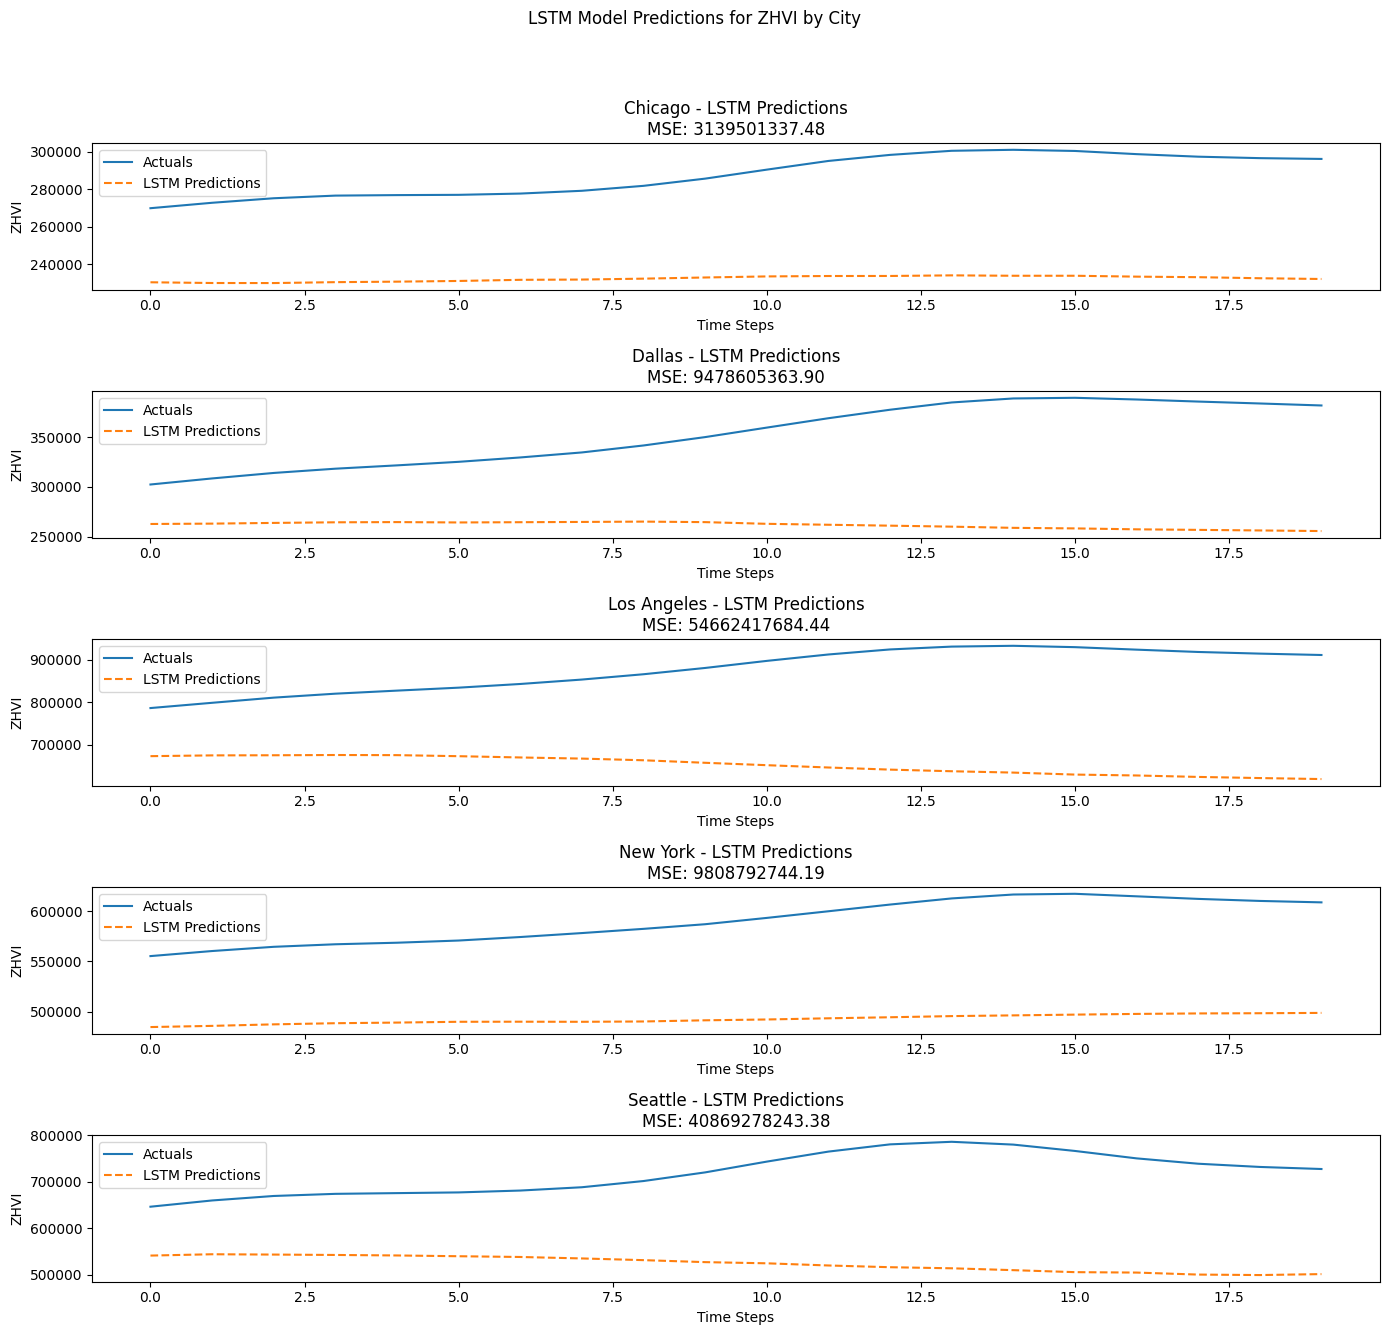

In [16]:
# Plotting the results for each city
fig, axs = plt.subplots(len(merged_df['City'].unique()), 1, figsize=(14, 14))
fig.suptitle('LSTM Model Predictions for ZHVI by City')

for idx, city in enumerate(merged_df['City'].unique()):
    axs[idx].plot(actual_vals[city], label='Actuals')
    axs[idx].plot(lstm_preds[city], label='LSTM Predictions', linestyle='--')
    axs[idx].set_title(f'{city} - LSTM Predictions\nMSE: {mse_results[city]:.2f}')
    axs[idx].set_xlabel('Time Steps')
    axs[idx].set_ylabel('ZHVI')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
# LSTM Baseline model MSE
mse_results

{'Chicago': 3139501337.482724,
 'Dallas': 9478605363.895016,
 'Los Angeles': 54662417684.44311,
 'New York': 9808792744.18788,
 'Seattle': 40869278243.38065}